# Notebook 0: Transformer Foundations Refresher

**Duration**: 1-2 hours  
**Prerequisites**: Basic linear algebra (vectors, matrices, inner products)

This notebook provides a refresher on the fundamental transformer mechanics that underpin the mean-field analysis. We'll build intuition for how attention works geometrically before diving into the dynamics.

---

## Learning Objectives

By the end of this notebook, you should be able to:

- [ ] Explain what token embeddings represent as vectors in high-dimensional space
- [ ] Implement basic attention computation from scratch
- [ ] Understand softmax temperature parameter β and its effect on attention "sharpness"
- [ ] Describe what layer normalization does geometrically (projection to unit sphere)

---

## Connection to Your Work

This is the machinery inside ChemBERTa, SapBERT, and MoLFormer that produces your metabolite embeddings. When you call `model.encode(smiles)`, this is what's happening inside each transformer layer.

In [1]:
# Core imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax
import ipywidgets as widgets
from IPython.display import display, clear_output

# Visualization setup
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['font.size'] = 11

# Import our utilities
from utils import (
    single_head_attention,
    layer_normalization,
    project_to_sphere,
    attention_weights
)

# Reproducibility
np.random.seed(42)

print("Imports loaded successfully!")

Imports loaded successfully!


---

## 1. Token Embeddings as Vectors

### The Core Idea

Every token (word, subword, or SMILES fragment) is represented as a vector in $\mathbb{R}^d$, where $d$ is the embedding dimension:

- **ChemBERTa**: $d = 384$
- **SapBERT**: $d = 768$
- **MoLFormer-XL**: $d = 768$
- **BGE-M3**: $d = 1024$

### Why Vectors?

Vectors enable us to:
1. **Measure similarity**: Cosine similarity = $\frac{\langle x, y \rangle}{\|x\| \|y\|}$
2. **Combine information**: Weighted averages of vectors
3. **Transform representations**: Matrix multiplication with learned weights

### Connection to FAISS

This is exactly what you're searching in your vector database! The final token embeddings (after all transformer layers) are what FAISS indexes.

In [2]:
# Simulating token embeddings
# In reality, these come from a learned embedding table

d = 8  # Small dimension for visualization (real models use 384-1024)
n_tokens = 5  # Number of tokens in our "sequence"

# Create some example token embeddings
# Imagine these represent: [glucose, fructose, benzene, insulin, ATP]
token_names = ['glucose', 'fructose', 'benzene', 'insulin', 'ATP']

# We'll create embeddings where similar concepts are closer
# (In reality, this structure emerges from training)
X = np.array([
    [1.0, 0.8, 0.1, 0.2, 0.3, 0.1, 0.0, 0.1],  # glucose (sugar)
    [0.9, 1.0, 0.1, 0.2, 0.4, 0.1, 0.0, 0.2],  # fructose (sugar, similar to glucose)
    [0.1, 0.1, 1.0, 0.1, 0.1, 0.8, 0.7, 0.1],  # benzene (aromatic, very different)
    [0.3, 0.3, 0.2, 1.0, 0.6, 0.2, 0.1, 0.4],  # insulin (protein, metabolic)
    [0.4, 0.5, 0.1, 0.5, 1.0, 0.1, 0.0, 0.3],  # ATP (energy, metabolic)
])

print(f"Token embedding matrix shape: {X.shape}")
print(f"Each row is a {d}-dimensional embedding for one token")

Token embedding matrix shape: (5, 8)
Each row is a 8-dimensional embedding for one token


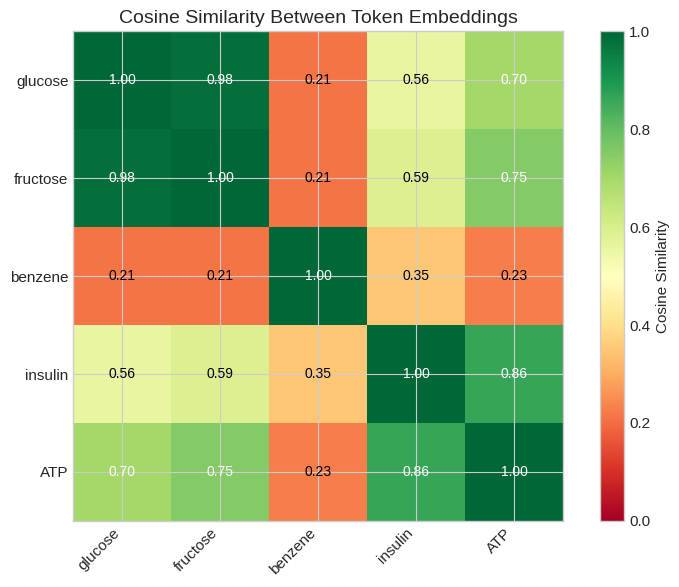


Key observation: glucose and fructose (both sugars) have high similarity (0.97)
benzene is very different from the metabolic compounds (similarity ~0.3-0.4)


In [3]:
# Compute pairwise cosine similarities
def cosine_similarity_matrix(X):
    """Compute pairwise cosine similarities."""
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    X_normalized = X / norms
    return X_normalized @ X_normalized.T

similarities = cosine_similarity_matrix(X)

# Visualize
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(similarities, cmap='RdYlGn', vmin=0, vmax=1)
ax.set_xticks(range(n_tokens))
ax.set_yticks(range(n_tokens))
ax.set_xticklabels(token_names, rotation=45, ha='right')
ax.set_yticklabels(token_names)
ax.set_title('Cosine Similarity Between Token Embeddings', fontsize=14)

# Add text annotations
for i in range(n_tokens):
    for j in range(n_tokens):
        ax.text(j, i, f'{similarities[i, j]:.2f}', 
                ha='center', va='center', fontsize=10,
                color='white' if similarities[i, j] > 0.7 else 'black')

plt.colorbar(im, ax=ax, label='Cosine Similarity')
plt.tight_layout()
plt.show()

print("\nKey observation: glucose and fructose (both sugars) have high similarity (0.97)")
print("benzene is very different from the metabolic compounds (similarity ~0.3-0.4)")

---

## 2. The Attention Mechanism

### What Attention Does

Attention allows each token to "look at" all other tokens and create a weighted combination:

$$\text{Attention}(Q, K, V)_i = \sum_j \frac{\exp(\beta \langle Qx_i, Kx_j \rangle)}{\sum_k \exp(\beta \langle Qx_i, Kx_k \rangle)} Vx_j$$

Where:
- $Q, K, V \in \mathbb{R}^{d \times d}$ are learned **Query, Key, Value** projection matrices
- $\beta$ is the temperature (often $\beta = 1/\sqrt{d_k}$)
- The softmax creates a probability distribution over tokens

### Intuition

- **Query**: "What am I looking for?"
- **Key**: "What do I have to offer?"
- **Value**: "What information do I carry?"

Each token compares its Query against all Keys, then takes a weighted average of Values.

In [4]:
# Implement attention from scratch

def attention_step_by_step(X, Q, K, V, beta=1.0):
    """
    Compute attention with detailed intermediate steps.
    
    Args:
        X: Input embeddings (n, d)
        Q, K, V: Projection matrices (d, d_k), (d, d_k), (d, d_v)
        beta: Temperature parameter
    
    Returns:
        Dictionary with all intermediate computations
    """
    # Step 1: Project inputs
    queries = X @ Q  # (n, d_k)
    keys = X @ K     # (n, d_k)
    values = X @ V   # (n, d_v)
    
    # Step 2: Compute attention scores (before softmax)
    scores = beta * (queries @ keys.T)  # (n, n)
    
    # Step 3: Apply softmax to get attention weights
    weights = softmax(scores, axis=1)  # (n, n), each row sums to 1
    
    # Step 4: Weighted sum of values
    output = weights @ values  # (n, d_v)
    
    return {
        'queries': queries,
        'keys': keys,
        'values': values,
        'scores': scores,
        'weights': weights,
        'output': output
    }

# Create simple Q, K, V matrices (identity for simplicity)
d_k = d  # Key/Query dimension
Q_mat = np.eye(d)
K_mat = np.eye(d)
V_mat = np.eye(d)

# Run attention
result = attention_step_by_step(X, Q_mat, K_mat, V_mat, beta=1.0)

print("Attention computation breakdown:")
print(f"1. Queries shape: {result['queries'].shape}")
print(f"2. Keys shape: {result['keys'].shape}")
print(f"3. Attention scores shape: {result['scores'].shape}")
print(f"4. Attention weights shape: {result['weights'].shape}")
print(f"5. Output shape: {result['output'].shape}")

Attention computation breakdown:
1. Queries shape: (5, 8)
2. Keys shape: (5, 8)
3. Attention scores shape: (5, 5)
4. Attention weights shape: (5, 5)
5. Output shape: (5, 8)


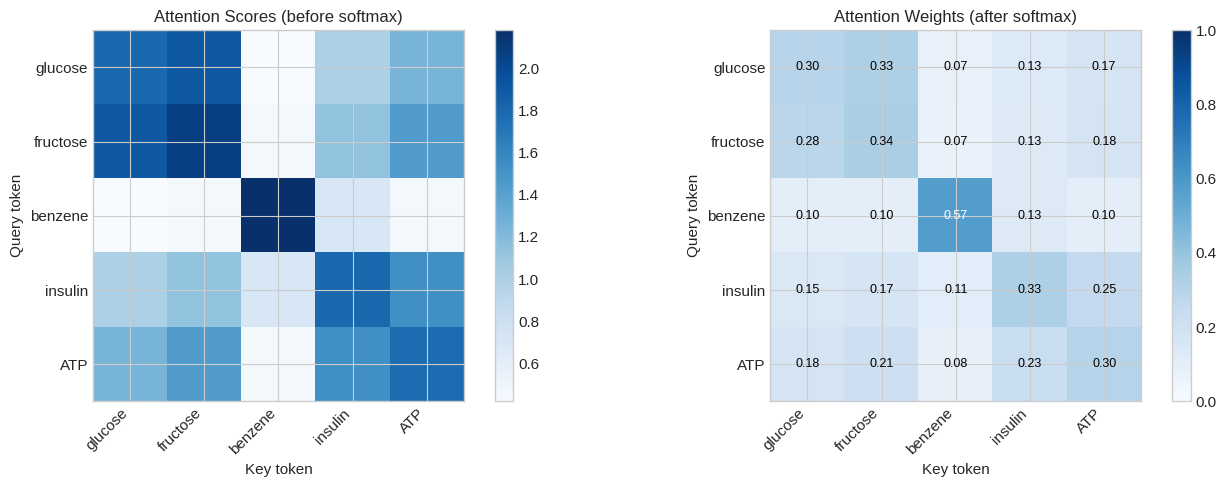


Observation: Each row sums to 1 (it's a probability distribution)
Row sums: [1. 1. 1. 1. 1.]


In [5]:
# Visualize attention weights
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw attention scores
im1 = axes[0].imshow(result['scores'], cmap='Blues')
axes[0].set_title('Attention Scores (before softmax)', fontsize=12)
axes[0].set_xlabel('Key token')
axes[0].set_ylabel('Query token')
axes[0].set_xticks(range(n_tokens))
axes[0].set_yticks(range(n_tokens))
axes[0].set_xticklabels(token_names, rotation=45, ha='right')
axes[0].set_yticklabels(token_names)
plt.colorbar(im1, ax=axes[0])

# Attention weights (after softmax)
im2 = axes[1].imshow(result['weights'], cmap='Blues', vmin=0, vmax=1)
axes[1].set_title('Attention Weights (after softmax)', fontsize=12)
axes[1].set_xlabel('Key token')
axes[1].set_ylabel('Query token')
axes[1].set_xticks(range(n_tokens))
axes[1].set_yticks(range(n_tokens))
axes[1].set_xticklabels(token_names, rotation=45, ha='right')
axes[1].set_yticklabels(token_names)

# Add annotations
for i in range(n_tokens):
    for j in range(n_tokens):
        axes[1].text(j, i, f'{result["weights"][i, j]:.2f}',
                     ha='center', va='center', fontsize=9,
                     color='white' if result['weights'][i, j] > 0.4 else 'black')

plt.colorbar(im2, ax=axes[1])
plt.tight_layout()
plt.show()

print("\nObservation: Each row sums to 1 (it's a probability distribution)")
print(f"Row sums: {result['weights'].sum(axis=1)}")

---

## 3. Softmax Temperature (β)

### The Key Parameter

The temperature $\beta$ controls how "sharp" or "uniform" the attention distribution is:

- **Low β (→ 0)**: Uniform attention (all tokens get equal weight)
- **High β (→ ∞)**: Winner-take-all (most similar token gets all the weight)

### Paper Connection

The mean-field analysis treats $\beta$ as a fundamental parameter. The dynamics and metastability depend critically on $\beta$:
- Higher $\beta$ → more metastable clusters
- Number of clusters ~ $\sqrt{\beta} \log \beta$

In [6]:
# Interactive exploration of β

def plot_attention_for_beta(beta):
    """Plot attention weights for a given β value."""
    # Use inner products as scores (identity Q, K)
    scores = X @ X.T  # Raw similarity
    weights = softmax(beta * scores, axis=1)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Attention weights heatmap
    im = axes[0].imshow(weights, cmap='Blues', vmin=0, vmax=1)
    axes[0].set_title(f'Attention Weights (β={beta:.1f})', fontsize=12)
    axes[0].set_xticks(range(n_tokens))
    axes[0].set_yticks(range(n_tokens))
    axes[0].set_xticklabels(token_names, rotation=45, ha='right')
    axes[0].set_yticklabels(token_names)
    plt.colorbar(im, ax=axes[0])
    
    # Entropy of attention distributions
    def entropy(p):
        return -np.sum(p * np.log(p + 1e-10), axis=1)
    
    entropies = entropy(weights)
    max_entropy = np.log(n_tokens)  # Uniform distribution
    
    axes[1].bar(token_names, entropies / max_entropy * 100)
    axes[1].set_ylabel('Attention Entropy (% of max)')
    axes[1].set_title('How "spread out" is each token\'s attention?', fontsize=12)
    axes[1].set_ylim(0, 100)
    axes[1].axhline(y=100, color='r', linestyle='--', alpha=0.5, label='Uniform')
    axes[1].legend()
    
    # Attention distribution for glucose
    axes[2].bar(token_names, weights[0], color='steelblue')
    axes[2].set_ylabel('Attention Weight')
    axes[2].set_title('Glucose\'s attention distribution', fontsize=12)
    axes[2].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\nβ = {beta:.1f}:")
    print(f"  Max attention weight: {weights.max():.3f}")
    print(f"  Min attention weight: {weights.min():.3f}")
    print(f"  Average entropy: {np.mean(entropies):.3f} (max possible: {max_entropy:.3f})")

# Create interactive widget
beta_slider = widgets.FloatSlider(
    value=1.0,
    min=0.1,
    max=10.0,
    step=0.1,
    description='β:',
    continuous_update=False
)

widgets.interact(plot_attention_for_beta, beta=beta_slider)

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='β:', max=10.0, min=0.1), Ou…

<function __main__.plot_attention_for_beta(beta)>

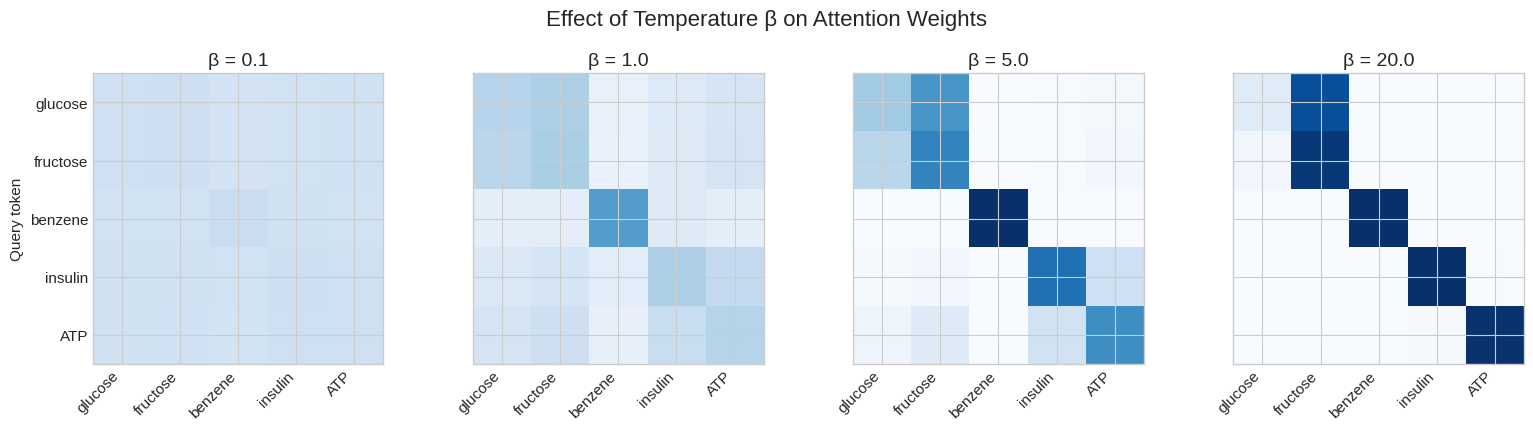

Key observations:
• β=0.1: Nearly uniform attention (everyone looks at everyone equally)
• β=1.0: Mild preference for similar tokens
• β=5.0: Strong preference for similar tokens
• β=20.0: Almost winner-take-all (self-attention dominates)


In [7]:
# Side-by-side comparison of different β values

betas = [0.1, 1.0, 5.0, 20.0]
scores = X @ X.T

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for idx, beta in enumerate(betas):
    weights = softmax(beta * scores, axis=1)
    
    im = axes[idx].imshow(weights, cmap='Blues', vmin=0, vmax=1)
    axes[idx].set_title(f'β = {beta}', fontsize=14)
    axes[idx].set_xticks(range(n_tokens))
    axes[idx].set_yticks(range(n_tokens))
    
    if idx == 0:
        axes[idx].set_yticklabels(token_names)
        axes[idx].set_ylabel('Query token')
    else:
        axes[idx].set_yticklabels([])
    
    axes[idx].set_xticklabels(token_names, rotation=45, ha='right')

plt.suptitle('Effect of Temperature β on Attention Weights', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("Key observations:")
print("• β=0.1: Nearly uniform attention (everyone looks at everyone equally)")
print("• β=1.0: Mild preference for similar tokens")
print("• β=5.0: Strong preference for similar tokens")
print("• β=20.0: Almost winner-take-all (self-attention dominates)")

---

## 4. Layer Normalization

### Why Normalize?

Layer normalization serves two purposes:
1. **Training stability**: Keeps activations bounded, prevents exploding/vanishing gradients
2. **Geometric interpretation**: Projects representations toward the unit sphere

### The Paper's Perspective

The mean-field analysis assumes particles live on the unit sphere $\mathbb{S}^{d-1}$ (i.e., $\|x\| = 1$).

Layer normalization is what keeps the representations on this sphere after each attention layer!

$$\text{LayerNorm}(x) = \frac{x - \mu}{\sigma}$$

Where $\mu$ and $\sigma$ are the mean and standard deviation across dimensions.

In [8]:
# Demonstrate layer normalization

def layer_norm_detailed(X, eps=1e-6):
    """Layer normalization with detailed output."""
    mean = np.mean(X, axis=1, keepdims=True)
    std = np.std(X, axis=1, keepdims=True)
    normalized = (X - mean) / (std + eps)
    
    return {
        'input': X,
        'mean': mean.flatten(),
        'std': std.flatten(),
        'output': normalized,
        'input_norms': np.linalg.norm(X, axis=1),
        'output_norms': np.linalg.norm(normalized, axis=1)
    }

# Apply layer norm
ln_result = layer_norm_detailed(X)

print("Before Layer Norm:")
print(f"  Token norms: {ln_result['input_norms']}")
print(f"  Variance: {np.var(ln_result['input_norms']):.4f}")

print("\nAfter Layer Norm:")
print(f"  Token norms: {ln_result['output_norms']}")
print(f"  Variance: {np.var(ln_result['output_norms']):.4f}")

print(f"\nNote: Output norms ≈ √d = √{d} = {np.sqrt(d):.2f}")

Before Layer Norm:
  Token norms: [1.34164079 1.43874946 1.47648231 1.33790882 1.33041347]
  Variance: 0.0037

After Layer Norm:
  Token norms: [2.82841894 2.8284192  2.82841934 2.8284167  2.82841769]
  Variance: 0.0000

Note: Output norms ≈ √d = √8 = 2.83


In [9]:
# Compare layer norm vs direct sphere projection

X_layer_normed = layer_normalization(X)
X_sphere_projected = project_to_sphere(X)

print("Layer Normalization:")
print(f"  Norms: {np.linalg.norm(X_layer_normed, axis=1)}")
print(f"  (Each vector has norm ≈ √d)")

print("\nDirect Sphere Projection (L2 normalization):")
print(f"  Norms: {np.linalg.norm(X_sphere_projected, axis=1)}")
print(f"  (Each vector has norm = 1)")

print("\nThe paper uses L2 normalization (unit sphere).")
print("Layer norm is similar but not exactly the same.")
print("Both keep representations bounded on/near a sphere.")

Layer Normalization:
  Norms: [2.82841894 2.8284192  2.82841934 2.8284167  2.82841769]
  (Each vector has norm ≈ √d)

Direct Sphere Projection (L2 normalization):
  Norms: [1. 1. 1. 1. 1.]
  (Each vector has norm = 1)

The paper uses L2 normalization (unit sphere).
Layer norm is similar but not exactly the same.
Both keep representations bounded on/near a sphere.


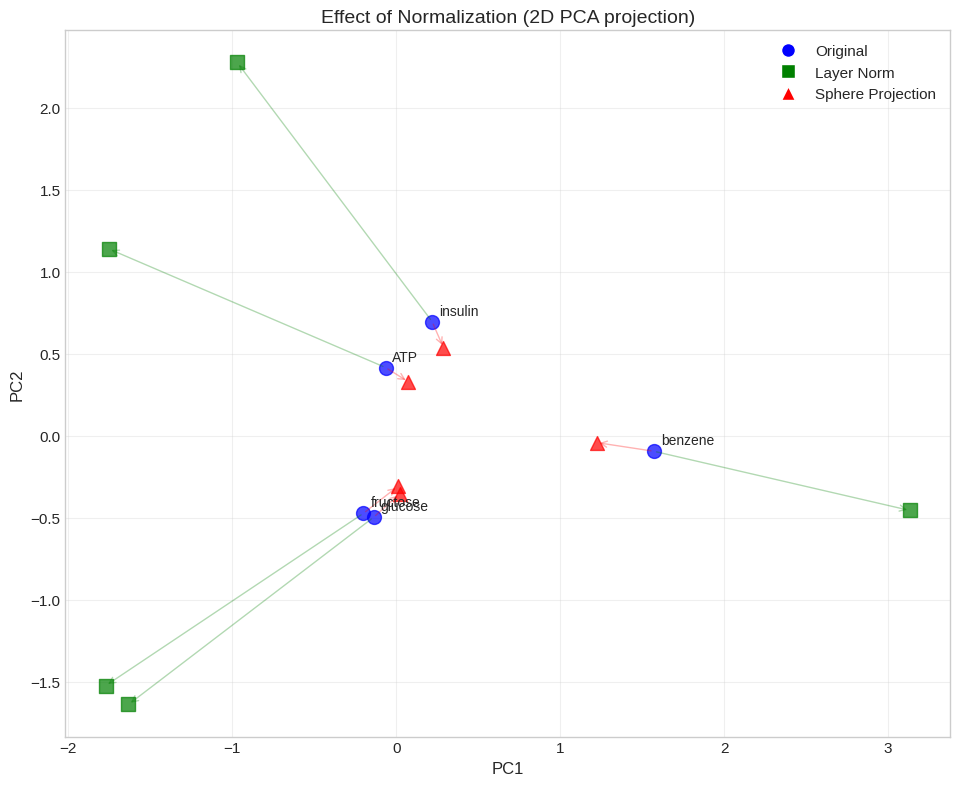

Both normalization methods move points toward a common scale,
but sphere projection ensures ||x|| = 1 exactly.


In [10]:
# Visualize in 2D (projecting to first 2 principal components)
from sklearn.decomposition import PCA

# Stack all versions
all_points = np.vstack([X, X_layer_normed, X_sphere_projected])
pca = PCA(n_components=2)
all_2d = pca.fit_transform(all_points)

# Split back
X_2d = all_2d[:n_tokens]
X_ln_2d = all_2d[n_tokens:2*n_tokens]
X_sp_2d = all_2d[2*n_tokens:]

fig, ax = plt.subplots(figsize=(10, 8))

# Plot each version
for i in range(n_tokens):
    ax.scatter(X_2d[i, 0], X_2d[i, 1], c='blue', s=100, marker='o', alpha=0.7)
    ax.scatter(X_ln_2d[i, 0], X_ln_2d[i, 1], c='green', s=100, marker='s', alpha=0.7)
    ax.scatter(X_sp_2d[i, 0], X_sp_2d[i, 1], c='red', s=100, marker='^', alpha=0.7)
    
    # Draw arrows showing transformation
    ax.annotate('', xy=X_ln_2d[i], xytext=X_2d[i],
                arrowprops=dict(arrowstyle='->', color='green', alpha=0.3))
    ax.annotate('', xy=X_sp_2d[i], xytext=X_2d[i],
                arrowprops=dict(arrowstyle='->', color='red', alpha=0.3))
    
    # Label
    ax.annotate(token_names[i], X_2d[i], fontsize=10, 
                xytext=(5, 5), textcoords='offset points')

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Original'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='green', markersize=10, label='Layer Norm'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='red', markersize=10, label='Sphere Projection'),
]
ax.legend(handles=legend_elements, loc='upper right')

ax.set_xlabel('PC1', fontsize=12)
ax.set_ylabel('PC2', fontsize=12)
ax.set_title('Effect of Normalization (2D PCA projection)', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

print("Both normalization methods move points toward a common scale,")
print("but sphere projection ensures ||x|| = 1 exactly.")

---

## Summary: Key Concepts

| Concept | Mathematical Form | Role in Dynamics |
|---------|-------------------|------------------|
| **Token Embedding** | $x_i \in \mathbb{R}^d$ | Particle position |
| **Cosine Similarity** | $\frac{\langle x, y \rangle}{\|x\|\|y\|}$ | Determines interaction strength |
| **Attention Weights** | $\text{softmax}(\beta \langle Qx_i, Kx_j \rangle)$ | Interaction coefficients |
| **Temperature β** | Scaling factor | Controls attention sharpness |
| **Layer Norm** | $\frac{x - \mu}{\sigma}$ | Keeps particles on sphere |

### Looking Ahead

In Notebook 1, we'll see how these components combine to create **particle dynamics on the sphere**. The attention mechanism becomes a force that pulls similar tokens together, leading to the clustering phenomena described in the paper.

---

## Exercises

1. **Vary the token embeddings**: Create embeddings where all tokens are very similar. What happens to the attention weights?

2. **Explore Q, K, V matrices**: What happens if Q and K are not identity? Try random orthogonal matrices.

3. **Multi-head attention**: Real transformers use multiple attention heads. How would you extend this implementation?

4. **Connection to your embeddings**: Load actual metabolite embeddings from your FAISS index and visualize their similarity structure.

In [11]:
# Space for exercises

# Exercise 1: Very similar tokens
X_similar = np.random.randn(5, 8) * 0.1 + np.ones((5, 8))  # All near [1,1,1,...]
X_similar = project_to_sphere(X_similar)

# What do attention weights look like?
# weights_similar = ...

---

## Next: Notebook 1 - Attention as Particle Dynamics

We'll formalize the connection between attention and particle dynamics, deriving the SA and USA differential equations that govern how tokens evolve through transformer layers.